(bayesian-nn)=
# Bayesian Neural Networks

## Introduction

In [13]:
import numpy as np
import pandas as pd
import torch
import pymc as pm
import pytensor

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import arviz as az

In [ ]:
# set general parameters
SEED = 123
torch.manual_seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)
torch.set_default_dtype(torch.float64)
sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = (5, 3)
floatX = pytensor.config.floatX

For this chapter we need some background knowledge of basic bayesian statistics as well as deep learning. For Deep Learning you might want to check out the introductory book by {cite}`Goodfellow-et-al-2016` which is [available online](https://www.deeplearningbook.org/) or the book by  {cite}`zhang2023dive`, which is [also available online](https://d2l.ai/) and provides additional code examples.
The ideas of Monte Carlo methods in this chapter are mainly taken from the book by {cite}`robert_monte_2004`. You might also want to check out the book by {cite}`johnson2022bayes` which has an [online version](https://www.bayesrulesbook.com/) as well. The paper by {cite}`Jospin_2022` provides an introduction to the specifics of Bayesian Neural Nets (BNN), assuming some knowledge in Neural Networks. To start with recall bayes formula:


$$
\underbrace{p(h|\mathcal{D})}_{Posterior} = \frac{\overbrace{p(h)}^{Prior} \cdot \overbrace{p(\mathcal{D}|h)}^{Likelihood}}{\underbrace{p(\mathcal{D})}_{Evidence/Marginal}}
$$
Also recall that in a bayesian setting we do not assume an unknown but fixed parameter but instead a distribution over parmeter(s) of interest. For Neural networks our hypothesis consists of a network architecture including weights, activation functions,  bias etc. but for now let us fix the overall architecture and let us consider the case of a simple Feed Forward Neural Networks (FNN) which can be considered a compostion of several functions:

$\hat{y} = f_{k} \circ f_{k-1} \circ f_{1} \circ ( {\bf{x}} )= f_{k}(f_{k-1}( \dotsm (f_{1}( {\bf{x}} ))) := \psi( {\bf{x}})$ for ${\bf{x}} \in \mathcal{X}$ and $\hat{y} \in \mathcal{Y}$. 

Typically this function is parametrized by some parameters ${\bf{\theta}}$. To indicate this one can write more precisely $\phi_{ \bf{\theta} }( {\bf{x}} )$ (subscript notation is used in order avoid '|' notation for bayesian conditioning). For Neural Networks these parameters are the weights and biases.Instead of assuming a fixed scalar quantity for each bias and weight term we assume a realization from some distribution to be specified upfront, e.g. if we denote the weights between unit i and j with $w_{i,j}$ we assume $w_{i,j} \sim G_{i,j}$ for some distribution $G_{i,j}$ (the analog holds for the bias term as well). One could also impose a probability distribution on the activations instead of the weights but both are valid choices of it own and one can be written in terms of the other (see {cite}`Jospin_2022` p. 6).
Reformulating Bayes rue from above with weight notation we have:

$$
\underbrace{p({\bf{w}} |\mathcal{D})}_{\sim epistemic} = \frac{p( {\bf{w}} ) \cdot \overbrace{p(\mathcal{D}| {\bf{w}} )}^{\sim aleatoric}}{p(\mathcal{D})}
$$

Choosing an appropriate posterior distribution one weights and biases can be difficult and there is still debate on how to choose an appropriate one. Typically a Gaussian is a common choice for BNNs due to desirable asymptotic properties (see  the introcutiory chapter of {cite}`neal1996`).
Our aim is to quantify the uncertainty associated with neural network predictions. The bayesian reformulation with a weight distribution together with the observed data distribution in form of the Likelihood allows us to decompose uncertainty:

The *aleatoric* uncertainity is associated with the likelihood since it captures the inherent noise associated with (incomplete) data we observe. The *epistemic* uncertainity is represented by the posterior distribution.
To calculate the posterior we need to compute the evidence (the denominator of Bayes Rule), which involves integration over a (typically) high dimensional distribution:

$$
p(\mathcal{D}) = \int_{W}p(\mathcal{D} \lvert {\bf{w}} )p({\bf{w}})d\bf{w}
$$

We integrate over the whole multidimensional space of all weights ${\mathcal{W}}$, typically this is only tractable for small dimensions. This is a common issue in bayesian statistics for which two appoaches are often used for solving: the first one is based on Markov Chain Monte Carlo (MCMC) methods which provides asymptotically exact results (for proper specified transition kernels), the other one is based on Variational Methods which restates the integration as an optimization problem for some variational distribution which depends itsef on certain parameters and is only an approximation without guarantee of caputuring the exact posterior.

Note that the posterior refers to the underlying parameters, here the weights and biases from some parameter space $\mathcal{W}$, and not to the actual variable of interest $y \in \mathcal{Y}$ . Rather the posterior is used in a next step to compute the **posterior predictive distribution**:

$$\mathbb{P}(Y^{\prime}|\mathcal{D}) = \int_{\mathcal{W}}\mathbb{P}(Y^{\prime}|{\bf w}) \underbrace{\mathbb{P}({\bf w}|\mathcal{D})}_{\text{posterior}}d {\bf w}$$

One can see that the posterior predictive distribution weights the posterior by the probability of observing $Y^{\prime}$ over all weights in our weight space $\mathcal{W}$

Having calulated the posterior distribution, assessing *epistemic* uncertainty can then be performed by drawing samples from the posterior (predictive) distribution.

Since weights and biases are random variables, training a neural network is now somewhat different. Following the notation of {cite}`Jospin_2022`(p.3) with minor adjustments the training can be stated in the following pseudocode of {prf:ref}`bnn-algo`.

```{prf:algorithm} BNN Inference with stochastic weights and biases[^bnn]
:label: bnn-algo

**Require:** prior distribution $p( {\bf{w}} )$, Likelihood $p(\mathcal{D} \lvert {\bf w}), Data \{{\bf{x}}_{i}\}_{i=1}^{N}$

1. Compute $p(\bf{w}|\mathcal{D}) = \frac{p( {\bf{w}}) \cdot p(\mathcal{D}|{\bf{w}})}{p(\mathcal{D})}$
2. For i=0 to N do:
	i. Draw $ {\bf{w}}_{i} \sim p( {\bf{w}} \vert \mathcal{D}) $
	ii. $ \hat{y}_{i} = \phi_{{\bf{\theta}_{i}}}({\bf{x})} $


3. Return $\{\hat{y}_{i}\}_{i=1}^{N}, {\bf{w}}_{i=1}^{N}$
```

Since $\{{\bf{y}}_{i} \}_{i=1}^{N}$ are draws from some distribution the end resut is not a single (best) prediction but rather a distribution over possible predictions we would get for different realizations of $\bf w$. To get a single prediction one can take the value with highest probability, e.g. the Maximum aposteriori prediction (MAP).

## Markov Chain Monte Carlo Methods

Our aim is to take sample from the posterior distribution but as was pointed out above computation can be hard, especially if we are in the unlucky and more realistic case of no conjugancy. The idea of MCMC is to draw samples from a sequence of random variables that will under certain conditions asymptotically converege to the desired distribution of interest. This sequence is called a Markov Chain:

````{prf:definition}
:label: mc-def
Let $S:=X_{1},X_{2},...$ be a sequence of random variables.
$S$ is called a Markov Chain if $\mathbb{P}(X_{i}|X_{1},X_{2},..X_{i-1}) = \mathbb{P}(X_{i}|X_{i-1})$ $\forall$ $i$ $\in$ $\{2,3,...\}$

- $\mathbb{P}(X_{1})$ is called the **initial distribution**.
- $\mathbb{P}(X_{i}|X_{i-1})$ is called the **transition probability distribution**.
- The support of $X_{i}$'s is called the **state space** of the Markov Chain
````

A Markov Chain can have certain important properties which are stated below. A tourough treatment can be found in {cite}`robert_monte_2004` on page 207 onwards.
- **Stationarity**: $\forall k,i$ $\in$ $\{1,2,..\}$, the sequence $(X_{i+1},...,X_{i+k})$ does not depend on the choice of $i$.
- **Reversibility**: The distribution of pairs $(X_{i}, X_{i+1})$ from $S$ is exchangeable.
- **Recurrence**: Each state $\mathcal{A}$ will be reached an infinite amount of times in expectation.
  
Reversibility implies Stationarity which ensures that for some $i$ we can make the claim that if $X_{i}$ has a certain distribution, say $\pi$ the so does $X_{i+1}$, e.g. $X_{i+1} \sim \pi$ (the stationary distribution is therefore also the limiting distribution). An import choice for achieving this is to select a suitable transition probability (also called Kernel). Especially if the Kernel is *irreducible* (roughly speaking all possible states can be reached in finite steps) stationarity can be concluded. One of the most prominent versions of MCMC sampling is the Metropolis Hastings algorithms:

```{prf:algorithm} Metropolis Hastings
:label: MH-algo

**Inputs** Given initial value $X^{0}$, target distribution $f$, Kernel $q$

**Output** Sequence of RV $(X^{n}, X^{n+1},...)

1. Until convergence criterion met:
2. Draw $Y_{t}$ from $q(y|x^{(t)})$

	2.1 Calculate acceptance probability $\alpha(x,y) := \min{1, \frac{f(y) \times q(x|y)}{f(x) \times q(y|x)}}$
    2.3 Drawn random uniform number $u \sim U(0,1)$
	2.2 If \alpha \greq u$
        Set $X^{(t+1)} = Y_{t}$
    2.5. Else
        X^{(t+1)} = x^{(t)}

Altough for the Metropolis Hasting algorithms convergence *guarantees* can be shown, a typical issue is convergence *rate* since it might just take too long until we get draws that can be considered to  be from the desired target distribution. Hamiltonian MCMC methods and adaptions thereof like the *NUTS-Sampler* try to solve this issue and are presented briefly. For a more tourough treatment and reference to related literature one can read into the STAN user manual which is [available online](https://mc-stan.org/docs/reference-manual/mcmc.html).
The idea of Hamiltonian MCMC is to introduce a momentum variable $\rho$ to speed up the process. If we denote the posterior distribution of parameters $\theta$ and momentum by $p(\theta)$ we can write the negative logarithm as $p(\rho, \theta) = p(\rho|\theta) p(\theta) = T(\rho|\theta) + V(\theta)$ by using logarithm laws and proper definition of $T$ and $V$ (to get the gist of the method we stick to the univariate case). For some given initial value of $\theta$ a simultaneous update for $\theta$ and $\rho$ can be phrased as a system of two differential equations which can be solved using the leapfrog algorithm, which requires a discretization step $\epsilon$ and a stepsize $L$ as input. Due to possible numerical errors in this step the newly calculated values of $\rho$ and $\theta$ are accepted only with a certain probability, similar to the MH algorithm above. The idea of the NUTS-sampler now is to adaptively set $\epsilon$ and $L$ in each iteration, typically handled differently in an early warm-up phase and thereafter leading to faster convergence results.

In the following we will consider the wine data; we will implement our bayesian neural networks using `PyMc` and sample from the predictive distribution to asses epistemic uncertainty:

In [15]:
X_wine, y_wine = load_wine(return_X_y = True)

X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine,
                                                                        test_size=1,
                                                                        random_state = SEED)

Here again we define the Wine model we encountered in the Deep Ensemble chapter. We will need the learned weights to specifiy the expected values for our distributions. For convenience we retrain and state the model again:

In [16]:
class WineModel(torch.nn.Module):
    def __init__(self):
        super(WineModel, self).__init__()
        self.fc1 = torch.nn.Linear(X_train_wine.shape[1], 30)
        self.fc2 = torch.nn.Linear(30, 20)
        self.fc3 = torch.nn.Linear(20, 3, bias = False)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def train_model(nn, X_train, y_train, classification = True, n_epochs = 800, bootstrap = True, boot_size = 0.75):
    """
    Train a singe DNN.
    """

    # create boostrap sample
    if bootstrap:
        assert boot_size > 0 and boot_size < 1
        idx = np.arange(X_train.shape[0])
        n_boot = int(np.ceil(int(boot_size * len(idx))))
        idx_boot = np.random.choice(idpredict_modelx, size = n_boot, replace=False)
        X_train = X_train[idx_boot]
        y_train = y_train[idx_boot]

    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    
    learning_rate = 0.001
    
    if classification:
        criterion = torch.nn.CrossEntropyLoss()
    else:
        criterion = torch.nn.MSELoss()
        y_train = y_train.unsqueeze(1)
        
    optimizer = torch.optim.Adam(nn.parameters(), lr=learning_rate)

    # train for n_epochs
    acc_loss = []
    for epoch in range(n_epochs):
        nn.train()
    
        # Forward pass
        outputs = nn(X_train)
        loss = criterion(outputs, y_train)
        acc_loss.append(loss.detach().item())
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return acc_loss
    
def predict_model(model, X_test, classification = True):
    X_test = torch.from_numpy(X_test)
    model.eval()
    with torch.no_grad():
        pred = model(X_test).numpy()
        if classification:
           pred = pred.argmax(axis = 1)
    return pred

In [17]:
nn_wine = WineModel()
loss_wine = train_model(nn_wine, X_train_wine, y_train_wine, bootstrap = False)
wine_train_preds = predict_model(nn_wine, X_train_wine)

Just for a sanity check, let us see whether we did actually sucessfully learn on the data:

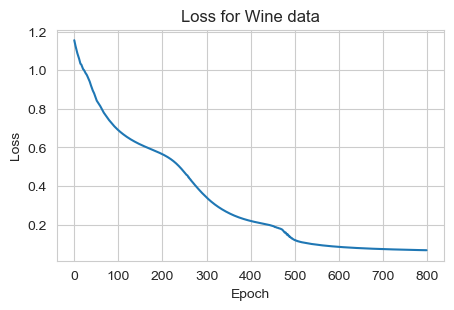

In [18]:
plt.plot(loss_wine)
plt.title("Loss for Wine data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Okay, the loss seems to converge to some minimum. Now let us see how our predicted values of wine classes are distributed compared to the original values:

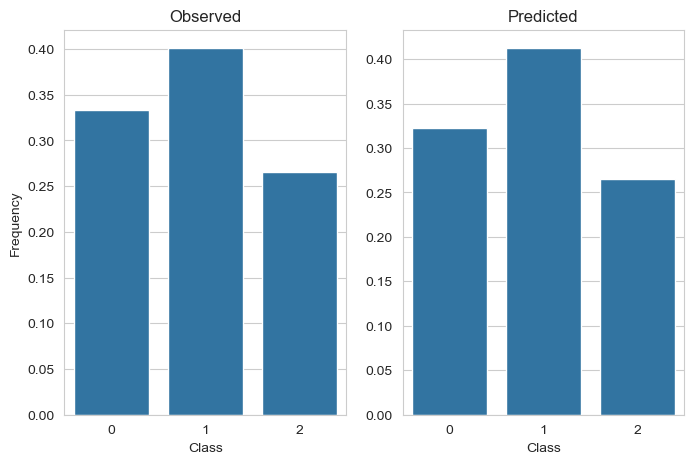

In [19]:
fix, ax = plt.subplots(1,2, figsize = (8,5))

_, counts = np.unique(y_train_wine, return_counts = True)
counts = counts / sum(counts)
sns.barplot(counts, ax = ax[0])
ax[0].set_ylabel("Frequency")
ax[0].set_title("Observed")
ax[0].set_xlabel("Class")
_, counts = np.unique(wine_train_preds, return_counts = True)
counts = counts / sum(counts)
sns.barplot(counts, ax = ax[1])
ax[1].set_title("Predicted")
ax[1].set_xlabel("Class")
plt.show()

Our model seems to have learned sucessfully since training loss went down and the predicted class distribution of our training data resembles the original. Let us now store the weight parameters in the variable `wine_state` and go on with the bayesian version of our trained network:

In [20]:
wine_state = nn_wine.state_dict()

In PyMc we have the option to label dimensions which will make auto generated plots more readable. Therefore we set coordinates for the size of each hidden layer 'h_<layer position' as well as for our observations and the training colums.

In [21]:
coords_wine = {
    "h_1": np.arange(wine_state["fc1.weight"].shape[0]),
    "h_2": np.arange(wine_state["fc2.weight"].shape[0]),
    "h_3": np.arange(wine_state["fc3.weight"].shape[0]),
    "train_cols": np.arange(X_train_wine.shape[1]),
    "obs_id": np.arange(X_train_wine.shape[0])
}

A critical choice is the variance of the weights: we assumed each weight is normally distributed where the expected value equals the weight value we extracted from the optimized model. Since the weights are typically in ranges around zero a too high variance would too much. Therefore we choose a variance of 0.05 for each normal. The model needs to be defined in a certain contex which specifies the relation between the random variables. In our case the layer architecture:

In [22]:
scale = 0.05
with pm.Model(coords = coords_wine) as bnn_wine:

    ann_input = pm.Data("ann_input", X_train_wine, dims = ("obs_id", "train_cols"))
    ann_output = pm.Data("ann_output", y_train_wine, dims = "obs_id")

    # set expected value and variance for normals
    # each entry of weight matrix is a normal, no correlation
    mu_w_1 = wine_state["fc1.weight"].T.numpy()
    mu_b_1 = wine_state["fc1.bias"].numpy()
    sigma_w_1 = np.ones(mu_w_1.shape) * scale
    sigma_b_1 = np.ones(mu_b_1.shape) * scale

    mu_w_2 = wine_state["fc2.weight"].T.numpy()
    mu_b_2 = wine_state["fc2.bias"].numpy()
    sigma_w_2 = np.ones(mu_w_2.shape) * scale
    sigma_b_2 = np.ones(mu_b_2.shape) * scale

    mu_w_3 = wine_state["fc3.weight"].T.numpy()
    sigma_w_3 = np.ones(mu_w_3.shape) * scale

    # create normal distributed weights and biases
    w_1 = pm.Normal("w_1", mu_w_1, sigma_w_1, dims = ("train_cols", "h_1"))
    b_1 = pm.Normal("b_1", mu_b_1, sigma_b_1, dims = "h_1")
    w_2 = pm.Normal("w_2", mu_w_2, sigma_w_2, dims = ("h_1", "h_2"))
    b_2 = pm.Normal("b_2", mu_b_2, sigma_b_2, dims = "h_2")
    w_3 = pm.Normal("w_3", mu_w_3, sigma_w_3, dims = ("h_2", "h_3"))


    act_1 = pm.Deterministic("act_1", pm.math.tanh(pm.math.dot(ann_input, w_1) + b_1))
    act_2 = pm.Deterministic("act_2", pm.math.tanh(pm.math.dot(act_1, w_2) + b_2))
    act_3 = pm.Deterministic("act_3", pm.math.softmax(pm.math.dot(act_2, w_3), 1))

    out = pm.Categorical("out",act_3, observed = ann_output, dims = "obs_id")
    

We can also make use of the `arviz` package and visualize the conceptual setup of our model in so called plate notation (explanation below). We use the letter 'w' to denote a weight random variable and 'b' to denote a bias random variable.

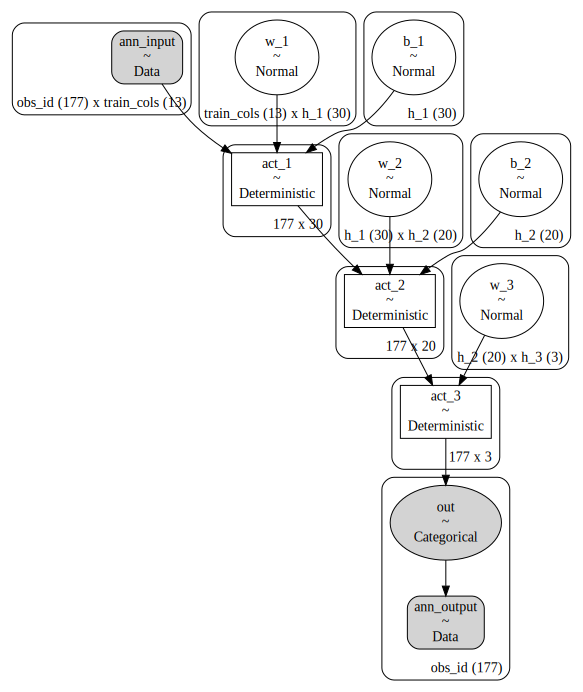

In [23]:
pm.model_to_graphviz(bnn_wine)

Each 'plate' indicates a repetition of data. Since we have 177 training observations we have 177 repetitions. A round circle represents a latent random variable which is unobserved (weights and biases), a grey circle an observed random variable (input and output data) and a rectangle some deterministic entity without distributional assumptions.

We can make use of build in random variables generators and sample weights, say 500 from a normal for each component:

In [24]:
%%time

with bnn_wine:
    trace = pm.sample(500)
    # by convention the created inference data is often called trace or idata (sorthand for 'inference data')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_1, b_1, w_2, b_2, w_3]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 46 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


CPU times: user 9.29 s, sys: 2.31 s, total: 11.6 s
Wall time: 1min 11s


There are several things to notice. First, by default the *NUTS-sampler* is used. Second, notice that the computation did actually take quite some time, considering we have a fairly small model and take only a few samples. Also, we draw 4 times a sample sequence, a common choice in MCMC setting for diagnostic reasons. Now lets take a look at the result. For simplicity only the bias terms are shown since we have too many weights in each layer to get a clear picture that is not too cluttered. On the left the estiated density from the samples is plotted and on the right sampled values from each chain.

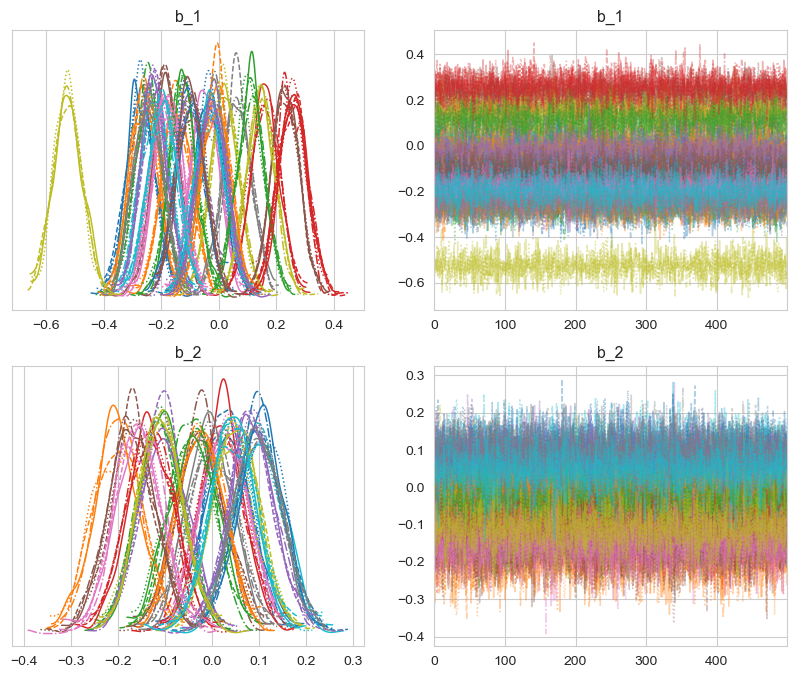

In [25]:
_ = az.plot_trace(trace, var_names= ["b_1", "b_2"], figsize=(10, 8))

What we see is what we would expect: each bias term is norally distributed with mean given by the previously trained model and some given variance (which is the same for all bias terms).<br>
On the right side we can see the realizations of each draw for each bias term. Since we do not see any autocorrelation and for each bias term it appears to be a random draw around its mean so we do not go any deeper in diagnositic checks that would be typically done in MCMC methods.
Next we can calculate *posterior predictive* quantitites based on our posterior distribution over the weights and biases:

In [26]:
with bnn_wine:
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


Output()

If we did set up the mean values for our weights corecctly the posterior predictive distribution should resemble the actual distribution in our training data since (since our model predicted fairly well).

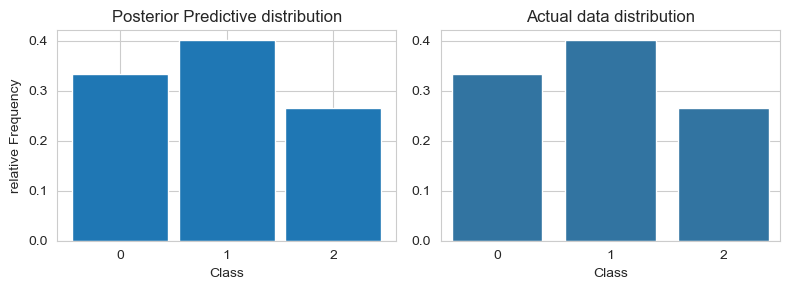

In [27]:
fig, ax = plt.subplots(1,2, figsize=(8, 3))
az.plot_dist(trace.posterior_predictive["out"], kind = "hist", ax = ax[0])
ax[0].set_title("Posterior Predictive distribution")
ax[0].set_ylabel("relative Frequency")
ax[0].set_xlabel("Class")
_, counts = np.unique(y_train_wine, return_counts = True)
counts = counts / sum(counts)
sns.barplot(counts, ax = ax[1])
ax[1].set_title("Actual data distribution")
ax[1].set_xlabel("Class")
plt.tight_layout()
plt.show()

To further stress the point that we are actually facing a distribution over predicted values and not a single prediction let us consider  two datapoints: An hitherto unobserved test point and the first encountered training point.

In [28]:
print(f"Actual class test data point:      {y_test_wine}")
print(f"Predicted class: test data point:  {predict_model(nn_wine, X_test_wine)}")
print(f"Actual class first training point: {y_train_wine[0]}")

Actual class test data point:      [2]
Predicted class: test data point:  [2]
Actual class first training point: 1


Now let us create a combination between the covariate values for the class 2 and class 1 predicted data points (for the sake of argument let's ignore wheter this is a meaningful operation or not).

In [29]:
test = 0.5 * X_train_wine[0] + 0.5 * X_test_wine

We can again form a predictive distributon and obtain the following:

In [30]:
with bnn_wine:
    pm.set_data({"ann_input": test, "ann_output": y_test_wine},
                coords = {"obs_id": np.arange(X_test_wine.shape[0])})
    test_data = pm.sample_posterior_predictive(trace)

Sampling: [out]


Output()

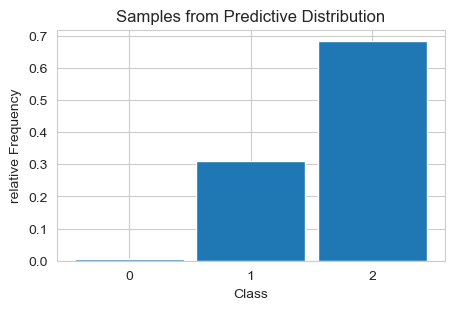

In [31]:
_ = az.plot_dist(test_data.posterior_predictive["out"], kind = "hist")
plt.title("Samples from Predictive Distribution")
plt.xlabel("Class")
plt.ylabel("relative Frequency")
plt.show()

Still the correct prediction in terms of maximum predictive aposteriori mode is class 2 but we can observe that roughly 30% of our sampled values would opt for class 1! Actually a tiny franction of samples from our weights also resulted in a Class 0 prediction (otherwise there would be no block in the picture). 

In [32]:
with bnn_wine:
    pm.set_data({"ann_input": test, "ann_output": y_test_wine},
                coords = {"obs_id": np.arange(X_test_wine.shape[0])})
    test_data = pm.sample_posterior_predictive(trace)

Sampling: [out]


Output()

## Variational Methods

A nice property of MCMC methods is that asymptotically we get valid posterior distributions. The price we pay is time and computational burdens since we may need a long "burn-in" period and multiple chains are typically used to assess convergence.
A possible solution is to dismiss asymptocically correct results and live with an "tolerable" approximation $q_{\phi}$ of the true posterior distribution which typically depends on some parameters $\phi$. Ideally we want to have $q_{\phi}({\bf w})$ close to $p({\bf w} \vert {\mathcal{D}})$, therefore one needs to assess the discrepancy between distributions. One often used distance measure between two distribution $f$ and $g$ is the Kullback-Leibler Divergence:

$$KL(f \vert \vert g) = \mathbb{E}_{f} \left[log \left( \frac{f({\bf x})}{g({\bf x})} \right) \right] =
    \int_{\mathcal{X}} f({\bf x}) \times log \left( \frac{f({\bf x})}{g({\bf x})} \right) d {\bf x}$$

Where expectation is taken with respect to the "target" distribution $f$. Notably the Kullback-Leibler Divergence is non-negative, takes a value of zero if $f$ equals $g$ and is not symmetric (and therefore does not fulfill the definition of a metric).
If the support of the variational distribution does not lie within the support of the posterior distribution one can see that $KL(f \vert \vert g) = \infty$. Therefore minimizing KL divergence needs to take this into account.

Now Consider the following functional:
$$ t(q_{\phi}) = \int_{\mathcal{W}} q_{\phi} \times log \left( \frac{q_{\phi}({\bf w})}{p( {\bf w}, \mathcal{D})} \right) d {\bf w}$$
Rewriting we get:

\begin{align*}
    \\ \int q_{\phi}({\bf w}) \times log \left( \frac{q_{\phi}({\bf w})}{p( {\bf w}, \mathcal{D})} \right) d {\bf w} 
     & = \int q_{\phi}({\bf w}) \times log \left( \frac{q_{\phi}({\bf w})}{p({\bf w} \vert \mathcal{D}) \times p(\mathcal{D})} \right) d {\bf w} 
    \\ & = \int q_{\phi}({\bf w}) \times \left[ log \left( \frac{q_{\phi}({\bf w})}{p({\bf w} \vert \mathcal{D})}\right) - log (p(\mathcal{D})) \right]d {\bf w} 
    \\ & = \int q_{\phi}({\bf w}) \times log \left( \frac{q_{\phi}({\bf w})}{p({\bf w} \vert \mathcal{D})} \right) d {\bf w}  -log(p(\mathcal{D})) \underbrace{\int q_{\phi}({\bf w}) d {\bf w}}_{=1}
    \\ & = KL(q_{\phi} \vert \vert p) - log(\underbrace{p(\mathcal{D})}_{\text{evidence}})
\end{align*}

Where we used the fact that densities integrate to one  next to the product rule for probabilities as well as logarithm rules.
One can see that the  negative log-evedince term is an upper bound on the functional $t(q_{\phi})$ since $KL(q_{\phi} \vert \vert p) \geq 0$  and 
$t(q_{\phi}) = KL(q_{\phi} \vert \vert p) - log(p(\mathcal{D})) \Rightarrow ELBO \leq  log(p(\mathcal{D}))$ where ELBO is an abbreviation for *Evidence Lower Bound*, a common name for  $-t(q_{\phi})$ .
Therefore instead of minimizing Kullback-Leibler Divergence one can also maximize $ELBO$ (as $p(\mathcal{D})$ does not vary for given data).

Now let us reset the model to the original training data and fit an approximation of the actual distributon.<br>
By default PyMc uses a mean field approximation, a mixture of gaussian distributions.

In [33]:
with bnn_wine:
    pm.set_data({"ann_input": X_train_wine, "ann_output": y_train_wine},
                coords = {"obs_id": np.arange(X_train_wine.shape[0])})
    approx = pm.fit(n = 10_000)

Output()

Finished [100%]: Average Loss = 3,231.7


To check, whether we approximated the original target let us plot the approimation loss in terms of negative ELBO.
Since computing the gradient for the whole dataset doesn't scale well and is computational demanding, by default the gradient in each epoch is sampled once to approximate the gradient of the whole dataset (therefore the loss does vizually seem to be more noisy).

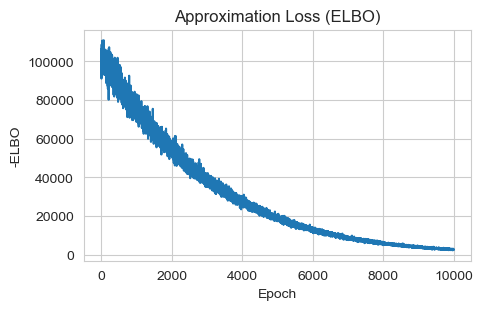

In [34]:
_ = plt.plot(approx.hist)
plt.title("Approximation Loss (ELBO)")
plt.ylabel("-ELBO")
plt.xlabel("Epoch")
plt.show()

In [35]:
with bnn_wine:
    new_trace = approx.sample(draws = 500)

Now a small check whether we captured the original data distribution, just as above:

In [36]:
with bnn_wine:
    ppc_new = pm.sample_posterior_predictive(new_trace)
    new_trace.extend(ppc)

Sampling: [out]


Output()

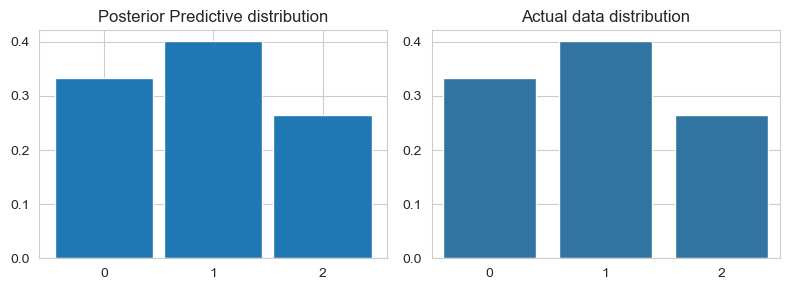

In [37]:
fig, ax = plt.subplots(1,2, figsize=(8, 3))
az.plot_dist(new_trace.posterior_predictive["out"], kind = "hist", ax = ax[0])
ax[0].set_title("Posterior Predictive distribution")
_, counts = np.unique(y_train_wine, return_counts = True)
counts = counts / sum(counts)
sns.barplot(counts, ax = ax[1])
ax[1].set_title("Actual data distribution")
plt.tight_layout()
plt.show()

Again we update the model with new data an create an artifical test case:

In [38]:
test = 0.5 * X_train_wine[0] + 0.5 * X_test_wine

In [39]:
with bnn_wine:
    pm.set_data({"ann_input": test, "ann_output": y_test_wine},
                coords = {"obs_id": np.arange(X_test_wine.shape[0])})
    new_test_data = pm.sample_posterior_predictive(new_trace)

Sampling: [out]


Output()

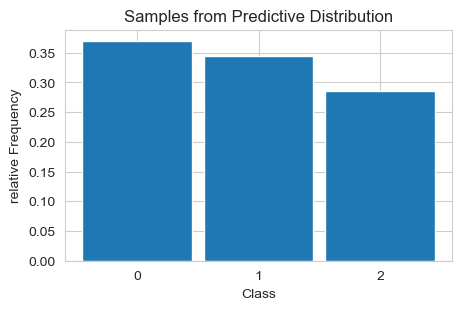

In [40]:
_ = az.plot_dist(new_test_data.posterior_predictive["out"], kind = "hist")
plt.title("Samples from Predictive Distribution")
plt.xlabel("Class")
plt.ylabel("relative Frequency")
plt.show()

The single best predicted class would still be class 2 but observe that we are facing much higher epistemic uncertainty. Class 0 and class 1 are not very unlikely anymore. In fact one could argue that no class is an obvious choice at all since all have roughly same estimated posterior predictive probability.